In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [3]:
train = pd.read_csv('data/train.csv')
# test = pd.read_csv('test.csv')
train.shape

(42000, 785)

In [4]:
# 获得特征和标签
X_train = train.drop('label', axis=1)
Y_train = train['label']
X_train.shape

(42000, 784)

In [5]:
# Normalize 正则化,==>[0,1]
def normalize(x):
    X_normale = (x-np.min(x))/(np.max(x)-np.min(x))
    return X_normale

In [6]:
def normalize2(x):
    X_normale = (x-x.mean(x))/x.std()
    return X_normale

In [7]:
# 显示图片
def display_image(image_data):
    plt.imshow(image_data.reshape((28, 28)));
    plt.show();

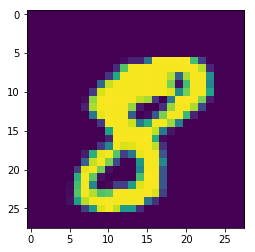

In [8]:
image_data = X_train.values
display_image(image_data[10])

In [9]:
# 处理数据
X_train = normalize(X_train.values)

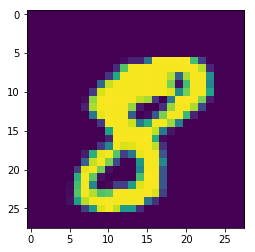

In [10]:
display_image(X_train[10])

In [11]:
# one hot

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(range(10))

# convert labels to one-hot 
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def one_hot_encode(x):
    one_hot = lb.transform(x)
    return one_hot

In [12]:
Y_train = one_hot_encode(Y_train)

In [13]:
Y_train = np.array(Y_train)
Y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.05, random_state=42)

In [15]:
X_train.shape

(39900, 784)

In [16]:
# images
x = tf.placeholder('float', shape=[None, X_train.shape[1]], name='image')
# labels
y = tf.placeholder('float', shape=[None, Y_train.shape[1]], name='label')

In [17]:
# (42000,784) => (42000,28,28,1)
# reshape to 4d tensor
image_width = 28
image_height = 28

# Input/Image
image = tf.reshape(x, [-1, image_width, image_height, 1])
print (image.get_shape()) 

(?, 28, 28, 1)


In [18]:
# # Convolution filter
# filter_size_width = 5
# filter_size_height = 5
# conv_num_outputs = 32
# color_channels = 1

# # Input/Image
# # x_input = tf.placeholder(tf.float32, shape=[None, 28, 28, color_channels])

# # Weight and bias
# weight = tf.Variable(tf.truncated_normal([filter_size_height, filter_size_width, color_channels, conv_num_outputs]))
# bias = tf.Variable(tf.zeros(conv_num_outputs))

In [19]:
# weight
def conv_weight(filter_size_height, filter_size_width, color_channels, conv_num_outputs):
    return tf.Variable(tf.truncated_normal([filter_size_height, filter_size_width, color_channels, conv_num_outputs]))

In [20]:
# bias
def conv_bias(conv_num_outputs):
    return tf.Variable(tf.zeros(conv_num_outputs))

In [21]:
# convolution
def conv2d(x, weight):
    return tf.nn.conv2d(x, weight, strides=[1, 1, 1, 1], padding='SAME')

In [22]:
# pooling
# [[0,3],
#  [4,2]] => 4

def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [23]:
# conv 
# conv_layer = conv2d(image, weight)
# conv_layer = tf.nn.bias_add(conv_layer, bias)
# conv_layer = tf.nn.relu(conv_layer)
# print(conv_layer.get_shape())

# Set the CNN model 
# [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out


In [24]:
# first convolutional layer

weight = conv_weight(5, 5, 1, 32)
bias = conv_bias(32)

# conv2d 
conv_layer = conv2d(image, weight)
conv_layer = tf.nn.bias_add(conv_layer, bias)
conv_layer = tf.nn.relu(conv_layer)
print(conv_layer.get_shape())

# Max Pooling
conv_layer = max_pool(conv_layer)
print(conv_layer.get_shape())

(?, 28, 28, 32)
(?, 14, 14, 32)


In [26]:
# second convolutional layer
weight = conv_weight(3, 3, 32, 64)
bias = conv_bias(64)

# conv2d
conv_layer = conv2d(conv_layer, weight)
conv_layer = tf.nn.bias_add(conv_layer, bias)
conv_layer = tf.nn.relu(conv_layer)
print(conv_layer.get_shape())

# Second Max Pooling
conv_layer = max_pool(conv_layer)
print(conv_layer.get_shape())

(?, 14, 14, 64)
(?, 7, 7, 64)


In [27]:
# dropout
conv_layer = tf.nn.dropout(conv_layer, 0.25)

In [28]:
x_flatten = tf.contrib.layers.flatten(conv_layer)
print(x_flatten.get_shape())

(?, 3136)


In [29]:
fc_layer = tf.contrib.layers.fully_connected(x_flatten, 256, activation_fn=tf.nn.relu)
print(fc_layer.get_shape())

(?, 256)


In [30]:
drop_out = tf.nn.dropout(fc_layer, 0.5)

In [31]:
output = tf.contrib.layers.fully_connected(drop_out, 10, activation_fn=None)
print(output.get_shape())

(?, 10)


In [32]:
# Model
logits = output

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
# defalut learning_rate=0.001
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [33]:
def batch_features_labels(batch_size):
    start = 0
    shuf = np.arange(len(X_train))
    np.random.shuffle(shuf)
    features = X_train[shuf]
    labels = Y_train[shuf]
    end = min(start + batch_size, len(X_train))    
    return features[start:end], labels[start:end]

In [34]:
test = pd.read_csv('data/test.csv')
test = normalize(test.values)

In [35]:
test_data = np.array(test)
test_data

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [45]:
epochs = 201
batch_size = 128
keep_probability = 0.75
keep_prob = tf.placeholder(tf.float32)

In [46]:

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    total_batch = math.ceil(len(X_train)/batch_size)
    # Training cycle
    for epoch in range(epochs):
        
        for i in range(total_batch):
            batch_x = X_train[batch_size*i:batch_size*(i+1)]
            batch_y = Y_train[batch_size*i:batch_size*(i+1)]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})     
            
#         batch_x, batch_y = batch_features_labels(batch_size)
#         sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
#         # Calculate batch loss and accuracy
#         loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        
        if epoch % 50 == 0:
            valid_acc = sess.run(accuracy, feed_dict={x: X_train[:batch_size],
                                                      y: Y_train[:batch_size],
                                                      keep_prob: 1.})
            print('epoch {},the train accuracy: {}'.format(epoch, valid_acc))

    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={x: X_test,
                                             y: Y_test,
                                             keep_prob: 1.})
    
    print('Testing Accuracy: {}'.format(test_acc))
    
    # save
    save_dir = 'save/dig_save'
    saver = tf.train.Saver()
    saver.save(sess, save_dir)      

setp 0,the train accuracy: 0.2734375
setp 50,the train accuracy: 0.9765625
setp 100,the train accuracy: 0.984375
setp 150,the train accuracy: 0.9921875
Testing Accuracy: 0.9809523820877075


In [47]:
# # test 1
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     test_prob = sess.run(logits,feed_dict={x: test})
#     test_labels = np.argmax(test_prob, axis=1)
    
#     submission = pd.DataFrame(data = {'ImageId':(np.arange(test_labels.shape[0])+1),'Label':test_labels})
#     submission.to_csv('digit_submission.csv',index=False)

In [49]:
# test result 
loaded_Graph = tf.Graph()
with tf.Session(graph=loaded_Graph) as sess:
    loader = tf.train.import_meta_graph(save_dir +'.meta')
    loader.restore(sess, save_dir)    
    # get tensors
    loaded_x = loaded_Graph.get_tensor_by_name('image:0')
    loaded_y = loaded_Graph.get_tensor_by_name('label:0')
    loaded_prob = loaded_Graph.get_tensor_by_name('logits:0')
    
    test_prob = sess.run(tf.argmax(loaded_prob,1), feed_dict = {loaded_x: test})    
    

INFO:tensorflow:Restoring parameters from save/dig_save


In [50]:
submission = pd.DataFrame(data = {'ImageId':(np.arange(test_prob.shape[0])+1),'Label':test_prob})
submission.to_csv('digit_submission0.csv',index=False)